# Text Classification of Tweets: Are they about a real disaster or not?

###### Project by Nicole Michaud, 12/30/2023

## Business Problem

Data has been accumulated from a number of tweets, some of which are about disasters, some of which are not. By creating a model for Natural Language Processing (NLP), we can predict whether or not a given tweet is about a real disaster or not. This can benefit companies who wish to monitor twitter in the event of an emergency.

## Data Understanding

Importing necessary packages, libraries, etc.:

In [1]:
import pandas as pd 
import numpy as np 
np.random.seed(42)
import nltk
nltk.download('punkt')
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from nltk import FreqDist
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolemichaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading the data:

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Data Exploration:

Viewing and gaining understanding of the data, its features, number of rows, any missing values, and more so I can preprocess the data accordingly.

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Dropping the 'keyword' and 'location' columns, as I won't be working with them. This project focuses on the text of the tweet. See miscellaneous notebook for investigation into the 'keyword' feature.

In [6]:
train_df = train_df.drop(columns = ['location', 'keyword'])
test_df = test_df.drop(columns = ['location', 'keyword'])
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


There doesn't appear to be any null values in the text column, but just to be sure I will drop null values in both the training and testing data.

In [7]:
train_df['text'].dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [8]:
test_df['text'].dropna(inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


Previewing a random tweet from both datasets to get an idea of how they might look before cleaning:

In [9]:
# Example of what is NOT a disaster tweet:
train_df[train_df["target"] == 0]["text"].values[6]

'London is cool ;)'

In [10]:
# Example of what IS a disaster tweet:
train_df[train_df["target"] == 1]["text"].values[20]

'Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k'

Visualizing what proportion of the training data are disaster tweets and non-disaster tweets:

<ipython-input-89-3d70ca5a3b9f>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


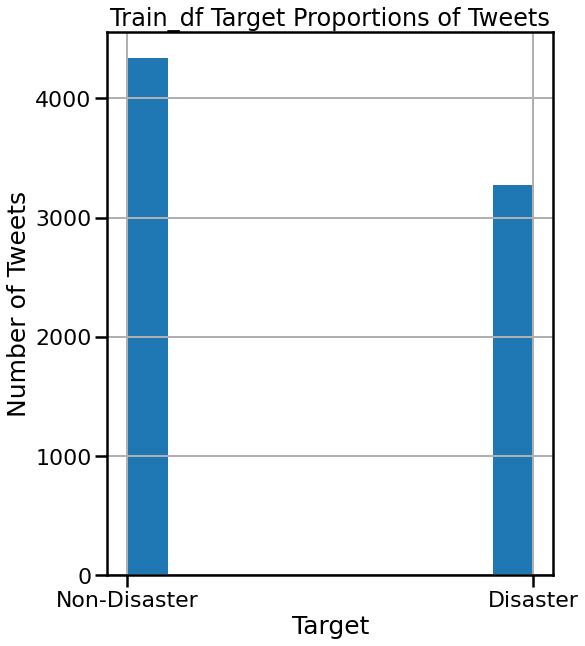

In [89]:
#from matplotlib import ticker
fig, ax = plt.subplots(figsize=(10,10))
proportions = train_df['target'].hist()

plt.locator_params(axis='x', nbins=2)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Non-Disaster'
labels[2] = 'Disaster'

ax.set_xticklabels(labels)

plt.xlabel('Target',fontsize=25)
plt.ylabel('Number of Tweets',fontsize=25)
plt.title('Train_df Target Proportions of Tweets');


Calculating the probabilities of disaster and non-disaster tweets in the training data:

In [12]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

In [13]:
P_disasters = len(disaster_tweets) /(len(disaster_tweets)+len(other_tweets))
P_non = len(other_tweets) /(len(other_tweets)+len(disaster_tweets))
print(P_disasters)
print(P_non)

0.4296597924602653
0.5703402075397347


This tells us that tweets in train_df have a higher probability of not being about a disaster.

## Data Preparation

<b>Cleaning text data:</b> Remove urls, tags (contain @), stopwords, punctuation, etc.

In [14]:
# Creating a function to perform all these cleaning steps at once
stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = no_nums.sub('', text) 
    #drop words '&amp' and 'via'
    text = re.sub("&amp", "", text)
    text = re.sub("via", "", text)
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_cleaned = train_df['text'].apply(clean_text)
test_df_cleaned = test_df['text'].apply(clean_text)
train_df_cleaned.head(10) 




0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked 'shelter place' notified offic...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                          i'm top hill see fire woods
8    there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area
Name: text, dtype: object

In [15]:
#Performing a train-test split on the training data to see how our models perform 
#before applying them to our testing data

X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [16]:
#Applying the text cleaning function to our data

X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

## Modeling

### Building a baseline model

In [17]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('Baseline model F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Baseline model F1 0.799114882744776
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.80      1904



Stemming the text to see if it improves our model:

In [18]:
#when stemming/lemmatizing, we are going to do the same to the stopwords, 
#so we don't want to remove them before this.

#Creating a function that cleans the text data without removing stopwords:

def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") 
    text = text.lower() 
    return text
    
train_df_cleaned_nostop = train_df.copy()

train_df_cleaned_nostop['text'] = train_df_cleaned_nostop['text'].apply(clean_text_nostop)

X_nostop = train_df_cleaned_nostop.text
y_nostop = train_df_cleaned_nostop.target
X_train_nostop, X_test_nostop, y_train_nostop, y_test_nostop = train_test_split(X_nostop, y_nostop, test_size=0.25, random_state = 42)


In [19]:
stemmer = SnowballStemmer(language="english")
tokenizer=word_tokenize

def stem_and_tokenize(document):
    tokens = tokenizer(document)
    return [stemmer.stem(token) for token in tokens]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [20]:
#Stemmed data model

stem_model = Pipeline([('vect', CountVectorizer(
                         stop_words=stemmed_stopwords,
                         tokenizer=stem_and_tokenize)),
               ('clf', MultinomialNB()),
              ])
stem_model.fit(X_train_nostop, y_train_nostop)


y_pred_stem= stem_model.predict(X_test_nostop)

print('Stemmed model F1 %s' % f1_score(y_pred_stem, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_stem))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", 'could', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Stemmed model F1 0.802174272578552
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1091
           1       0.80      0.74      0.77       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



<em>Stemming improved our model.</em>

Conducting GridSearchCV to see if tuning the hyperparameters in our best model will improve it further:

In [21]:
# First, need to manually tokenize/vectorize data since we won't be using a pipeline for this

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = vectorizer.transform(X_test_cleaned)

cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train_cleaned)
X_train_vec  = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)


X_test_vec = cv.transform(X_test_cleaned)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [22]:
#GridSearchCV
alphas = [0.5, 1.0, 1.5, 2.0, 2.5]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False]}
NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, scoring = 'f1', cv = 3)
grid.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
                         'fit_prior': [True, False]},
             scoring='f1')

In [23]:
grid.best_params_

{'alpha': 2.5, 'fit_prior': True}

In [22]:
tuned_model = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
)),
                        
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])

tuned_model.fit(X_train_nostop, y_train_nostop)

y_pred_tuned= tuned_model.predict(X_test_nostop)

print('Tuned model F1 %s' % f1_score(y_pred_tuned, y_test_nostop, average="macro"))

print(classification_report(y_test_nostop, y_pred_tuned))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", "'d", 'could', 'might', 'must', "n't", 'need', 'r', 'sha', 'v', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Tuned model F1 0.8022946797889032
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1091
           1       0.80      0.73      0.77       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [59]:
sns.set_context("poster")
final_clf_report = classification_report(y_test_nostop, y_pred_tuned)
# The following code is not mine, I adapted it from a stackoverflow user on how to create a classification report heatmap
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.3, cmap=cmap, vmin=0.0, vmax=1.0)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title, y=1.25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, number_of_classes=2, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    
    #drop initial lines
    lines = lines[2:]

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[: number_of_classes]:
        t = list(filter(None, line.strip().split('  ')))
        if len(t) < 4: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)


    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['Non-Disaster', 'Disaster']
    #'{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)
    figure_width = 20
    figure_height = len(class_names) + 10
    correct_orientation = True
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    plt.show()



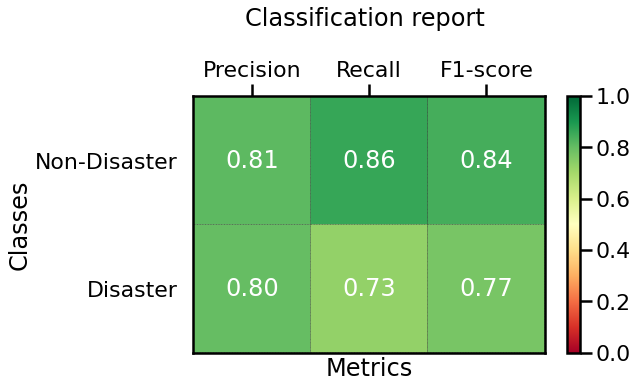

In [60]:
plot_classification_report(final_clf_report)

In [25]:
cnf_matrix = confusion_matrix(y_test_nostop, y_pred_tuned)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[943 148]
 [216 597]]


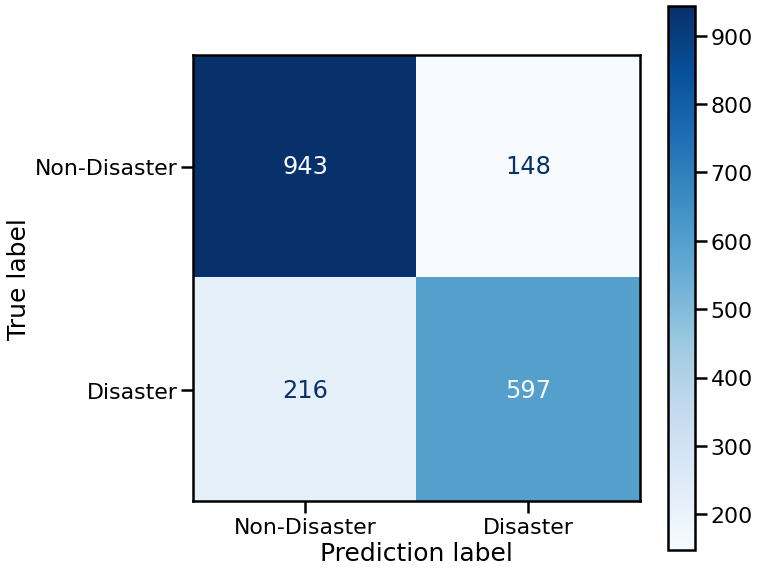

In [29]:
#CM Visualization:
fig, ax = plt.subplots(figsize=(10,10))
cm_1 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = ['Non-Disaster', 'Disaster'])
cm_1.plot(cmap=plt.cm.Blues, ax=ax)
plt.xlabel('Prediction label',fontsize=25)
plt.ylabel('True label',fontsize=25);

This model gave 943 True Negatives, 597 True Positives, 148 False Positives, and 216 False Negatives. 

Both false negatives and false positives are costly in this instance.

### Generating Predictions

In [29]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [30]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Before creating predictions on the sample submission csv, I want to try it on the test_df to make sure it works:


In [31]:
#Cleaning the test data:
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    return text
    
test_df_cleaned_nostop = test_df.copy()

test_df_cleaned_nostop['text'] = test_df_cleaned_nostop['text'].apply(clean_text_nostop)


In [32]:
test_df_cleaned_nostop.head()

,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities s...
2,3,there is a forest fire at spot pond geese are...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills in china and taiwan


In [33]:
test_df_sample = test_df_cleaned_nostop.copy()
test_df_sample['target'] = tuned_model.predict(test_df_sample['text'])

In [34]:
test_df_sample.head()

,id,text,target
0,0,just happened a terrible car crash,1
1,2,heard about earthquake is different cities s...,1
2,3,there is a forest fire at spot pond geese are...,1
3,9,apocalypse lighting spokane wildfires,1
4,11,typhoon soudelor kills in china and taiwan,1


In [35]:
test_df_sample['target'].value_counts()

0    2033
1    1230
Name: target, dtype: int64

This appears to have worked, so let's try it on the sample submission:

In [36]:
sample_submission["target"] = tuned_model.predict(test_df['text'])

In [37]:
sample_submission['target'].value_counts()

0    2031
1    1232
Name: target, dtype: int64

## Conclusion

### Recommendations:
- Model should be deployed to monitor twitter for disaster tweets

### Next Steps:
- Continue testing other models to see if performance can be improved
    - Use more tweets data
    - Use word embeddings
    - Flag top words/phrases of disaster tweets

______

## Contact me:
- LinkedIn: https://www.linkedin.com/in/nicole-michaud2/
- Email: michaud.nicole00@gmail.com
- Blog: https://medium.com/@nicolemichaud03
